Notebook to collect the information of the generation

### Import

In [1]:
import sys, os, re, yaml, pickle
from glob import glob
sys.path.append('../lib')

import time, datetime

In [2]:
import numpy as np
from scipy.stats import mode
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import humanfriendly
from progressBar import ProgressBar

In [3]:
import uproot as ur
import ROOT as rt
rt.gErrorIgnoreLevel = rt.kError
rt.RooMsgService.instance().setGlobalKillBelow(rt.RooFit.ERROR)
import root_numpy as rtnp

Welcome to JupyROOT 6.12/07


# Inputs

In [4]:
sample_dic_dir = '/storage/user/ocerri/work/CMSSW_10_2_3/src/ntuplizer/BPH_RDntuplizer/production/samples.yml'

In [5]:
class Bauble: pass

In [6]:
# setName = 'SignalRegion'
# outDic = {}

# outDic['mu'] = Bauble()
# outDic['mu'].sample = 'B0_MuNuDmst_PU0'

# outDic['tau'] = Bauble()
# outDic['tau'].sample = 'B0_TauNuDmst_PU0'

# outDic['Hc'] = Bauble()
# outDic['Hc'].sample = 'B0_DmstHc_PU0'

# outDic['Dstst'] = Bauble()
# outDic['Dstst'].sample = 'Bp_MuNuDstst_PU0'

In [7]:
setName = 'SidePT'
outDic = {}

outDic['JPsiKst'] = Bauble()
outDic['JPsiKst'].sample = 'B0_JpsiKst_PU0'

Gather the files

In [8]:
site_loc_conf = '/mnt/hadoop/store/user/ocerri'
ntuples_loc = '/storage/user/ocerri/BPhysics/data/cmsMC_private/{}/ntuples_B2*'
samples = yaml.load(open(sample_dic_dir))

for d in outDic.values():
    d.MINIAOD_dirs = []
    for directory in samples['samples'][d.sample]['parts']:
        aux = glob(site_loc_conf + directory[:-38].replace('ocerri-','') + '/*/*')
        d.MINIAOD_dirs += aux
    
    full_name = samples['samples'][d.sample]['dataset']
    d.ntuples_dir = glob(ntuples_loc.format(full_name))[0]

# Efficiency

In [9]:
def getEff(k,N):
    e = k/float(N)
    de = np.sqrt(e*(1-e)/N)
    return [e, de]

In [35]:
N_max = 30

for name, d in outDic.iteritems():
    print '\n--> ' + name
    xsec = []
    xsec_err = []
    N_gen_cuts = []
    N_acc = []
    eff= []
    eff_err = []
    
    print 'Fetching logs files location'
    step1log_list = []
    for directory in d.MINIAOD_dirs:
        step1log_list += glob(directory + '/step1log_*.root')
    if N_max > 0 and N_max < len(step1log_list):
        step1log_list = np.random.choice(step1log_list, N_max)
    
    print 'Analizing', len(step1log_list), 'logs'
    pb = ProgressBar(maxEntry=len(step1log_list))
    for i_j, step1log_file in enumerate(step1log_list):
#         print step1log_file
        pb.show(i_j)
        os.system('tail -n 50 ' + step1log_file + ' > tmp.log')
        step1_log_lines = open('tmp.log').readlines()
        for il, line in enumerate(reversed(step1_log_lines)):
            if line.startswith('Before Filter: total cross section'):
                aux = line[37:-4].split(' +- ')
                xsec.append(float(aux[0]))
                xsec_err.append(float(aux[1]))
                break
            elif line.startswith('Filter efficiency (event-level)='):
                l=line[34:-24]
                l = l.split(') = ')
                l[0] = l[0].split(') / (')
                l[1] = l[1].split(' +- ')
                l = np.array(l).astype(np.float)
                N_acc.append(l[0,0])
                N_gen_cuts.append(l[0,1])
                eff.append(l[1,0])
                eff_err.append(l[1,1])
            elif il > 40:
                print step1log_file
                print line
                break

    
    d.xsec = np.array(xsec)
    d.xsec_err = np.array(xsec_err)
    print 'Avg xsec: {:1.2e} pb'.format(np.mean(xsec))
    
    d.N_gen_cuts = np.array(N_gen_cuts)
    print 'Avg gen_cuts:', np.mean(N_gen_cuts).astype(np.int)
    
    d.N_acc = np.array(N_acc)
    print 'Avg acc: {:.0f}'.format(np.mean(N_acc))
    
    d.CMSSWFilterEff = np.array(eff)
    d.CMSSWFilterEff_err = np.array(eff_err)
    print 'Avg CMSSW Filter eff: {:1.2e}'.format(np.mean(eff))
    
    cand_out_list = glob(d.ntuples_dir + '/out/job*.out')
    N_analyzed = []
    N_trg = []
    N_cand = []
    eff = []
    for cand_out in cand_out_list:
        step5_log_lines = open(cand_out).readlines()
        eff_ln = []
        for line in reversed(step5_log_lines):
            if 'efficiency:' in line:
                eff_ln.append(line)

        aux = re.search('[0-9]+/[0-9]+', eff_ln[1]).group(0)
        aux = aux.split('/')
        N_analyzed.append(int(aux[1]))
        N_trg.append(int(aux[0]))
        
        aux = re.search(': [0-9]+/', eff_ln[0]).group(0)
        N_cand.append(int(aux[2:-1]))
    
    d.N_analyzed = np.array(N_analyzed)
    d.N_trg = np.array(N_trg)
#     print 'Avg N_trg:', float(np.sum(N_trg) / d.N_acc.shape[0])
    d.N_cand = np.array(N_cand)
#     print 'Avg N_cand:', float(np.sum(N_cand) / d.N_acc.shape[0])
    d.ntuplizerEff = d.N_cand.astype(np.float)/d.N_analyzed
    print 'Avg ntuplizer eff: {:1.2e}'.format(np.mean(d.ntuplizerEff))
    
    
    ## Sanity checks
    print 'Tot candidates:', np.sum(d.N_cand)
#     n1 = np.sum(d.N_analyzed)
#     n2 = np.sum(d.N_acc)
#     if n1 != n2:
#         print  np.sum(d.N_analyzed), np.sum(d.N_acc)
#         print n1-n2

    ## Save infos
    dump_d = {}
    dump_d['xsec'] = np.mean(d.xsec)
    dump_d['CMSSWFilterEff'] = np.mean(d.CMSSWFilterEff)
    dump_d['ntupplizerEff'] = np.mean(d.ntuplizerEff)   
    dump_d['TotCand'] = np.sum(d.N_cand)
    d.dump_d = dump_d


--> JPsiKst
Fetching logs files location
Analizing 30 logs
[####################]  100% - Tot. time: 3.8 s
Avg xsec: 1.49e+08 pb
Avg gen_cuts: 300000
Avg acc: 2997
Avg CMSSW Filter eff: 9.99e-03
Avg ntuplizer eff: 5.90e-02
Tot candidates: 592375


In [36]:
dump_dic = {}
for n, d in outDic.iteritems():
    dump_dic[n] = d.dump_d
pickle.dump(dump_dic, open('../data/'+setName+'MC_efficiencies.pickle', 'wb'))

JPsiKst


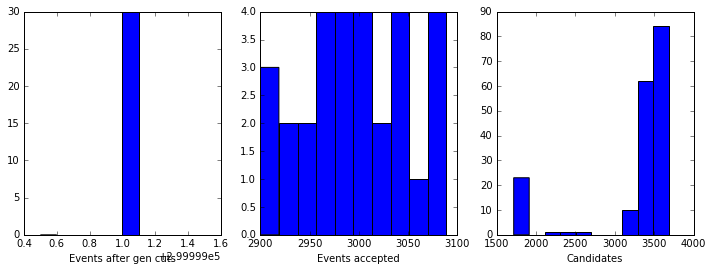

In [37]:
for name, d in outDic.iteritems():
    print name
    fig, ax = plt.subplots(1, 3, figsize=(12,4))
    ax[0].hist(d.N_gen_cuts)
    ax[0].set_xlabel('Events after gen cuts')
    ax[1].hist(d.N_acc)
    ax[1].set_xlabel('Events accepted')
    ax[2].hist(d.N_cand)
    ax[2].set_xlabel('Candidates')

# Time

In [ ]:
def bashDate2Unix(ln, debug=False):
    template = '%c'
    ln = ln.replace('CEST ', '')
    ln = ln.replace('UTC ', '')
    if debug:
        print ln
    else:
        t = time.mktime(datetime.datetime.strptime(ln, template).timetuple())
        return float(t)

In [ ]:
for name in outDic.keys():
    print '\n--> ' + name
    master_dir = outDic[name].dir + '/'
    d = outDic[name]
    d.driver_time = []
    d.run_time =[]
    d.tot_time =[]
    
    job_dir_list = glob(master_dir + 'jobs_out/out_*[0-9]')
    pb = ProgressBar(maxEntry=len(job_dir_list))
    for i_j, job_dir in enumerate(job_dir_list):
        pb.show(i_j)
        aux = os.path.basename(job_dir)
        n_job = int(aux[4:])
        
        fn = glob(master_dir + 'jobs_out/out/job_{}_*.out'.format(n_job-1))[0]
        if not os.path.isfile(fn): continue
        test_log_lines = open(fn).readlines()
        
        try:
            crono = [[],[],[],[],[]]
            for i, ln in enumerate(test_log_lines):
                for j in range(1,5):
                    if 'Step '+str(j) in ln or 'Running step '+str(j) in ln:
                        try:
                            crono[j-1].append(bashDate2Unix(test_log_lines[i+1][:-1]))
                        except:
                            print '\nError in job', n_job
                            crono[j-1].append(crono[j-1][-1])
            crono[4].append(bashDate2Unix(test_log_lines[-1][:-1]))

            driver_time = []
            run_time = []
            for i in range(4):
                driver_time.append(crono[i][1] - crono[i][0])
                run_time.append(crono[i+1][0] - crono[i][1])
            tot_time = crono[4][0] - crono[0][0]

            d.driver_time.append(driver_time)
            d.run_time.append(run_time)
            d.tot_time.append(tot_time)
        except:
            pass
        
    d.driver_time = np.array(d.driver_time)
    d.run_time = np.array(d.run_time)
    d.tot_time = np.array(d.tot_time)

In [ ]:
bins = plt.hist(d.tot_time/3600)
plt.xlabel('Total time [h]')
x = np.percentile(d.tot_time, 90)/3600
plt.plot([x,x], [0,np.max(bins[0])], 'm--', lw=3);

# Disk

In [ ]:
for name in outDic.keys():
    print '\n--> ' + name
    master_dir = outDic[name].dir + '/'
    d = outDic[name]
    d.MINIAOD_size = []
    
    job_dir_list = glob(master_dir + 'jobs_out/out_*[0-9]')
    pb = ProgressBar(maxEntry=len(job_dir_list))
    for i_j, job_dir in enumerate(job_dir_list):
        pb.show(i_j)
        aux = os.path.basename(job_dir)
        n_job = int(aux[4:])
        if not os.path.isfile(job_dir + '/step1.log'): continue
        fname_MINI = master_dir + 'jobs_out/out_MINIAODSIM_{}.root'.format(n_job)
        if not os.path.isfile(fname_MINI): continue
        d.MINIAOD_size.append(os.path.getsize(fname_MINI))
    
    d.MINIAOD_size = np.array(d.MINIAOD_size)
    print 'Avg MINIAOD size:', humanfriendly.format_size(np.mean(d.MINIAOD_size), binary=True)

# Print

In [ ]:
for n, d in outDic.iteritems():
    table = PrettyTable()
    table.field_names = ['Step', 'Sub', 'Eff [%]', 'Driver time [s]', 'Running time/evt [s]']
    
    e, de = getEff(np.sum(d.N_acc), np.sum(d.N_gen_cuts))
    dt = np.mean(d.driver_time[:, 0])
    dr_ev = np.mean(d.run_time[:, 0]/d.N_acc)
    table.add_row(['GEN-SIM', '-', '{:.2f} +/- {:.2f}'.format(100*e, 100*de), '{:.1f}'.format(dt), '{:.1f}'.format(dr_ev)])
    
    e, de = getEff(np.sum(d.N_gen_cuts), np.sum(d.N_gen))
    table.add_row(['', 'Pythia Gen', 'x {:.1f}'.format(1./e), '-', '-'])
    table.add_row(['', 'Gen Filter', '100.0', '-', '-'])
    e, de = getEff(np.sum(d.N_acc), np.sum(d.N_gen_cuts))
    table.add_row(['', 'CMSSW Filter', '{:.2f} +/- {:.2f}'.format(100*e, 100*de), '-', '-'])

    table.add_row(['RAW', '-', '100.0', '{:.1f}'.format(np.mean(d.driver_time[:,1])), '{:.1f}'.format(np.mean(d.run_time[:,1]/d.N_acc))])
    table.add_row(['AOD', '-', '100.0', '{:.1f}'.format(np.mean(d.driver_time[:,2])), '{:.1f}'.format(np.mean(d.run_time[:,2]/d.N_acc))])
    table.add_row(['MINIAOD', '-', '100.0', '{:.1f}'.format(np.mean(d.driver_time[:,3])), '{:.1f}'.format(np.mean(d.run_time[:,3]/d.N_acc))])
    
    e, de = getEff(np.sum(d.N_cand), np.sum(d.N_acc))
    table.add_row(['CAND', '-', '{:.2f} +/- {:.2f}'.format(100*e, 100*de), '-', '-'])
    e, de = getEff(np.sum(d.N_trg), np.sum(d.N_acc))
    table.add_row(['', 'BPH Trg', '{:.2f} +/- {:.2f}'.format(100*e, 100*de), '-', '-'])
    e, de = getEff(np.sum(d.N_cand), np.sum(d.N_trg))
    table.add_row(['', 'Cand. sel.', '{:.2f} +/- {:.2f}'.format(100*e, 100*de), '-', '-'])
    
    table.add_row(len(table.field_names)*[''])
    
    e, de = getEff(np.sum(d.N_cand), np.sum(d.N_gen_cuts))
    table.add_row(['Tot', '', '{:.3f} +/- {:.3f}'.format(100*e, 100*de), '{:.1f}'.format(np.mean(np.sum(d.driver_time, axis=1))), '{:.1f}(*)'.format(np.mean(np.sum(d.run_time, axis=1)/d.N_acc))])

    print n
    print table.get_string()
    
    tabsum = PrettyTable()
    tabsum.field_names = ['Evts req.', '# MINIAOD Evts', '# Cand.', 'Tot. Time [h]']
    
    MINIAOD_size = humanfriendly.format_size(np.mean(d.MINIAOD_size), binary=True)
    tabsum.add_row(['{:.0f}k'.format(1e-3*np.mean(d.N_gen_cuts)), '{:.0f} ({})'.format(np.mean(d.N_acc), MINIAOD_size), '{:.0f}'.format(np.sum(d.N_cand) / d.N_acc.shape[0]), '{:.1f}'.format(np.mean(d.tot_time)/3600.)])
    print tabsum.get_string()
    